In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
DATA_IN_PATH = './data-in/'

In [3]:
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', delimiter = '\t', quoting = 3)
# quoting=3 데이터에 quotes가 없다는 의미
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 150000


In [5]:
train_length = train_data['document'].astype(str).apply(len) #각각 len 함수 통과
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

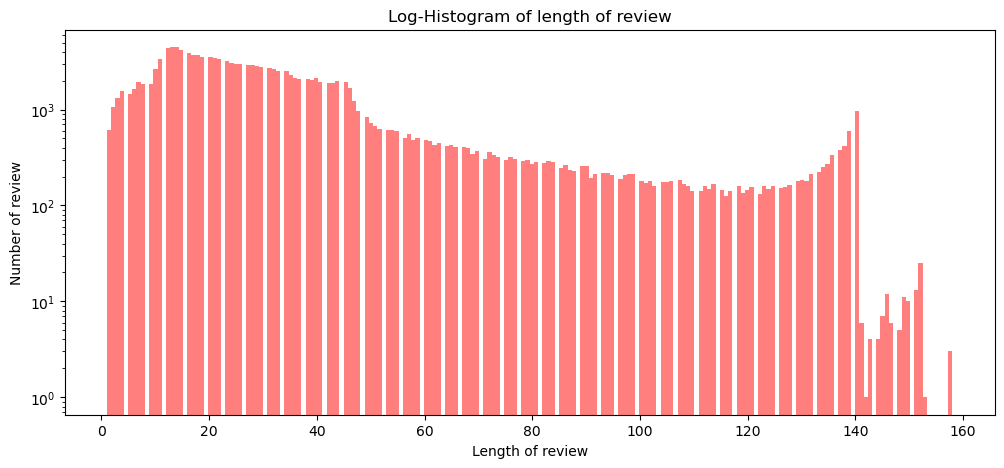

In [6]:
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r')
plt.yscale('log', nonpositive='clip') # y값이 너무 크니까 log로 표시
#non-positive values in y can be clipped to a very small positive number
# 그래프 제목
plt.title('Log-Histogram of length of review')
# 그래프 x 축 라벨
plt.xlabel('Length of review')
# 그래프 y 축 라벨
plt.ylabel('Number of review')
plt.show()

- 짧은 길이부터 140자까지 고르게 분포되어 있음  
- 20자 이하에 많이 분포되어 있다가 길이가 길어질 수록 점점 적어지다가 140자 부근에서 갑자기 많아짐  
- 140자 제한(한글 기준)이 있는 데이터이기 때문

In [7]:
print('리뷰 길이 최대 값: {}'.format(np.max(train_length)))
print('리뷰 길이 최소 값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

리뷰 길이 최대 값: 158
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간 값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


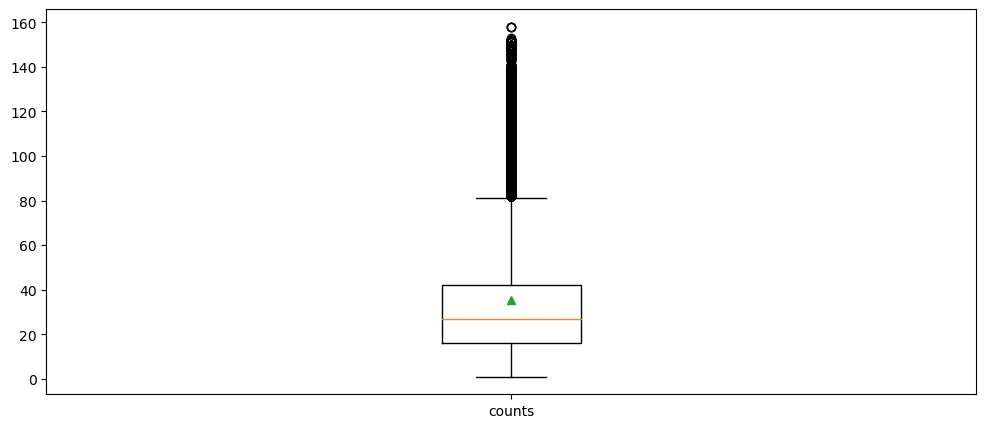

In [8]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(train_length, labels=['counts'], showmeans=True)
plt.show()

- 길이가 긴 데이터가 꽤 존재함  
- 중간값과 평균값은 아래쪽에 위치  
- 워드클라우드를 이용해 자주 사용된 어휘 알아보기  
- 사전 작업으로, 데이터 안에 들어 있는 문자열이 아닌 데이터는 모두 제거함

In [9]:
train_review = [review for review in train_data['document'] if type(review) is str]

In [10]:
train_review

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?',
 '걍인피니트가짱이다.진짜짱이다♥',
 '볼때마다 눈물나서 죽겠다90년대의 향수자극!!허진호는 감성절제멜로의 달인이다~',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 '담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을.',
 '취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지',
 'ㄱ냥 매번 긴장되고 재밋음ㅠㅠ',
 '참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다.그냥 까고싶어서 안달난것처럼 보인다',
 '굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐',
 '이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드!!♥',
 '약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.',
 '나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님',
 '보면서 웃지 않는 건 불가능하다',
 '재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남....바베트의 만찬은 이야기도 있

- 워드 클라우드는 기본적으로 영어 텍스트를 지원함  
- 한글을 사용하기 위해 한글 폰트를 설정해야 함

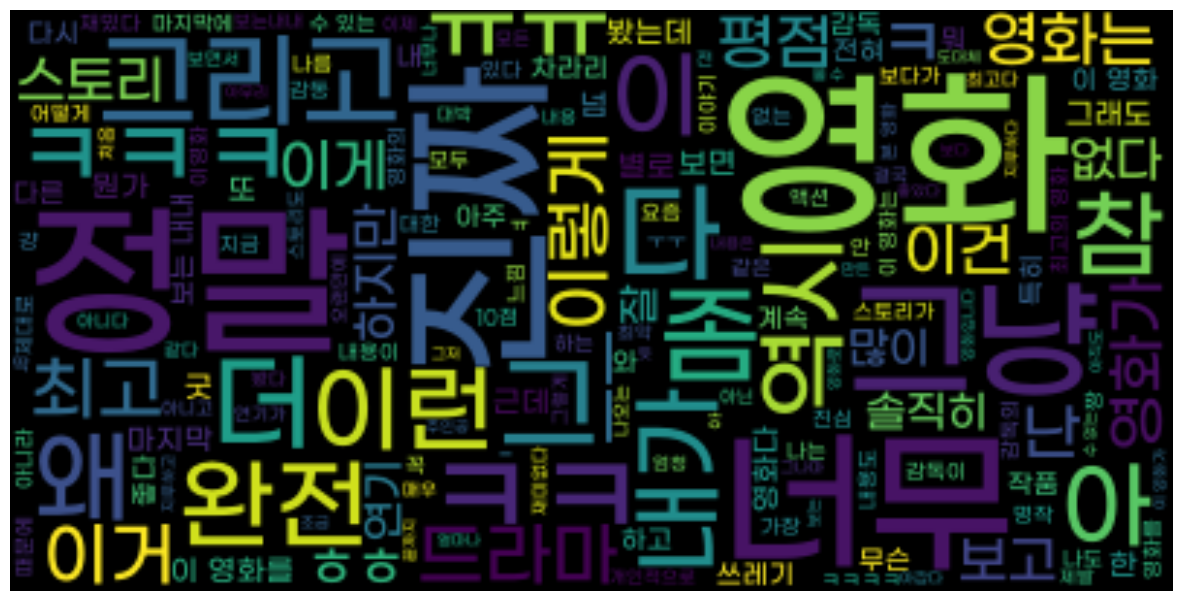

In [12]:
wordcloud = WordCloud(font_path = DATA_IN_PATH + 'GmarketSansMedium.otf').generate(' '.join(train_review))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

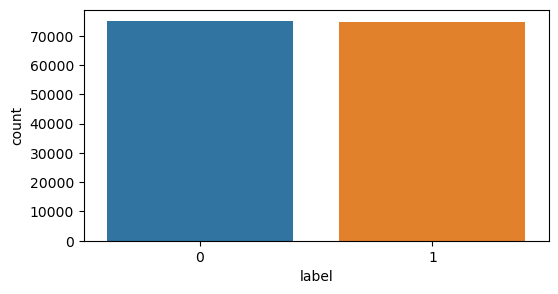

In [13]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(x=train_data['label'])
plt.show()

In [14]:
print("긍정 리뷰 개수: {}".format(train_data['label'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['label'].value_counts()[0]))

긍정 리뷰 개수: 74827
부정 리뷰 개수: 75173


- 각 리뷰의 단어 수 확인
- 각 데이터를 띄어쓰기 기준으로 나눠서 그 개수를 하나의 변수로 할당, 히스토그램 표시

In [15]:
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

In [18]:
print(type(train_word_counts)) #pd. Series 객체

<class 'pandas.core.series.Series'>


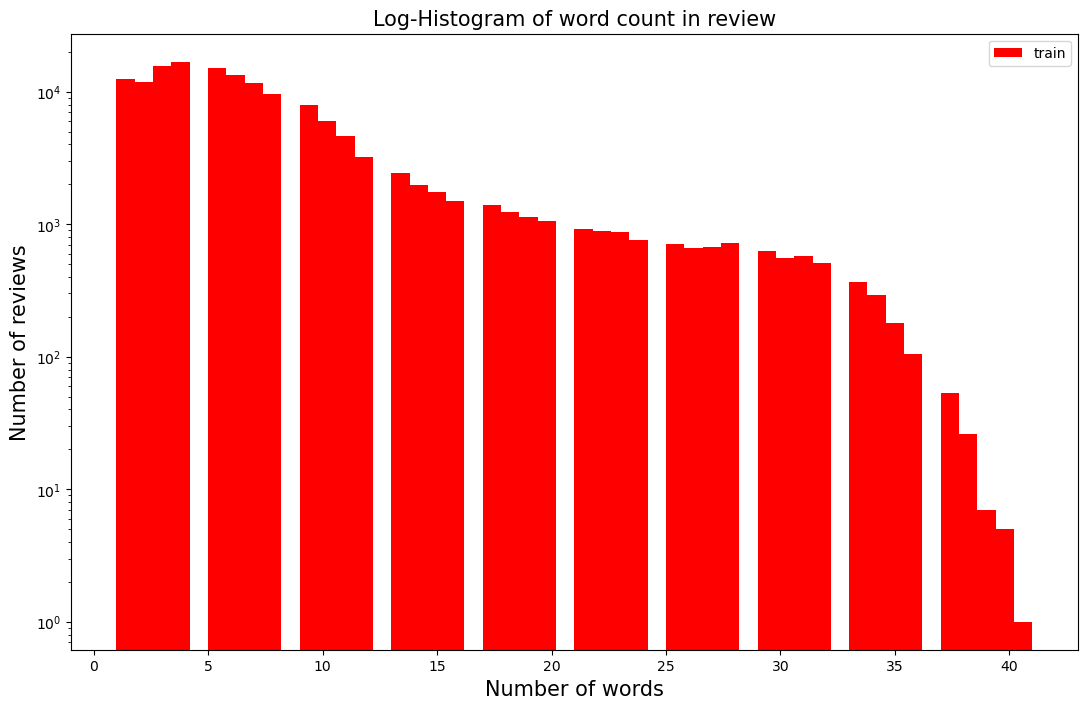

In [20]:
plt.figure(figsize=(13, 8))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonpositive='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)
plt.show()

- 갈이의 경우 대부분 5개 정도에 분포되어 있음
- 30개 이상의 데이터부터는 수가 급격히 줄어듬

In [22]:
print('리뷰 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('리뷰 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('리뷰 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 최대 값: 41
리뷰 단어 개수 최소 값: 1
리뷰 단어 개수 평균 값: 7.58
리뷰 단어 개수 표준편차: 6.51
리뷰 단어 개수 중간 값: 6.0
리뷰 단어 개수 제 1 사분위: 3.0
리뷰 단어 개수 제 3 사분위: 9.0


- 평균 7 ~ 8 개 정도의 단어 수를 가지고 있고, 중간값의 경우 6개 정도의 단어를 가지고 있음  
- 글자 수 제한때문에 영어 데이터에 비해 길이가 짧음  
- 이 경우 모델에 적용할 최대 단어수를 6개가 아닌 7개로 설정해도 큰 무리가 없음  

- 각 데이터에 대해 특수문자 유무를 확인  
- 리뷰에 자주 사용되는 특별한 특수문자는 없으므로 일반적인 마침표와 물음표만 확인

In [23]:
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x)) # 마침표
                  
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))

물음표가있는 질문: 8.25%
마침표가 있는 질문: 51.76%


In [25]:
import re
import json
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [26]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [27]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) #train_data ~ 에서 맨앞(가-힣ㄱ-ㅎㅏ-ㅣ, 스페이스) 을 제외한 것(^)이 등장하면 ""로 대체한다
# 모든 한글, 자음, 모음, 공백을 제외한 모든 것을 삭제
print(review_text)

아 더빙 진짜 짜증나네요 목소리


- 이렇게 처리된 문장에서 불용어를 제거하기 위해 문장을 단어로 나눠야 함  
- KoNLPy 라이브러리의 okt 객체를 사용  
- 형태소 분석기를 사용할 때 어간 추출을 사용해 어간이 추출된 단어로 나눔

In [28]:
okt=Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['아', '더빙', '진짜', '짜증나다', '목소리']


- 불용어 제거를 위해 불용어 사전을 만들어 적용

In [29]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['더빙', '진짜', '짜증나다', '목소리']


In [30]:
def preprocessing(review, okt, remove_stopwords=False, stop_words=[]):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [31]:
clean_train_review = []

for review in train_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가
        
print(clean_train_review[:4])

[['더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]


In [32]:
test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt', delimiter='\t', quoting=3 )

clean_test_review = []

for review in test_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가
        
print(clean_test_review[:4])

[['굳다', 'ㅋ'], [], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index

In [34]:
train_sequences[:3]

[[463, 20, 265, 664],
 [923, 465, 46, 604, 1, 219, 1459, 30, 969, 680, 24],
 [393, 2456, 25028, 2323, 5680, 2, 226, 13]]

In [35]:
print(word_vocab['더빙'])

463


In [36]:
MAX_SEQUENCE_LENGTH = 8 # 문장 최대 길이, 단어의 평균 개수가 8개 정도였기 때문

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화 #padding post는 뒤쪽으로 0
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

In [37]:
DATA_IN_PATH = './data-in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels) #신경망에 집어넣기 전 전처리된 데이터 저장

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)